# Neural Network Project
## Assignment -- Gesture Recognition
​
#### Problem Statement:
​
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

​
Practically, the coutput from this project is to predict the gesture and build a model which can help incresing the TV viewing experience—
​


In [ ]:
# Importing the necessary libraries

import numpy as np
import os
#from scipy.misc import imread, imresize
from skimage.transform import resize
from skimage.io import imread
import datetime
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

## The drive is mounted at the below location

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# importing some other libraries which will be needed for model building.

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers import LSTM
# from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

In [6]:
project_folder='gdrive/MyDrive/Colab Notebooks/Project_data'

## The train and validation path of the data

In [7]:
train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
batch_size = 64

## Let us create the Base Model

In [17]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [2,4,6,8,10,12,14,16,18,20,22,24,26]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,13,80,80,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    if item < len(imgs):
                      image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                      #crop the images and resize them. Note that the images are of 2 different shape
                      image = resize(image,(80,80)).astype(np.float32)

                      #and the conv3D will throw error if the inputs in a batch have different shapes
                      batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                      batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 #normalise and feed in the image
                      batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        if len(t) % batch_size != 0:
            batch_data = np.zeros((batch_size,13,80,80,3))
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    if item < len(imgs):
                      image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                      image = resize(image,(80,80)).astype(np.float32)
                      batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                      batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                      batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield does

In [15]:
curr_dt_time = datetime.datetime.now()
train_path = project_folder + '/' + 'train' #'Project_data\\train'
val_path = project_folder + '/' + 'val'  #'Project_data\\val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [36]:
train_path

'gdrive/MyDrive/Colab Notebooks/Project_data/train'

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

#write your model here
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(13,80,80,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [12]:
optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 13, 80, 80, 32)    2624      
                                                                 
 activation (Activation)     (None, 13, 80, 80, 32)    0         
                                                                 
 batch_normalization (Batch  (None, 13, 80, 80, 32)    128       
 Normalization)                                                  
                                                                 
 max_pooling3d (MaxPooling3  (None, 6, 40, 40, 32)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 40, 40, 64)     16448     
                                                                 
 activation_1 (Activation)   (None, 6, 40, 40, 64)     0

In [18]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [14]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [19]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  gdrive/MyDrive/Colab Notebooks/Project_data/train ; batch size = 60
Epoch 1/20
12/12 [==============================] - ETA: 0s - loss: 1.8535 - categorical_accuracy: 0.3556  Source path =  gdrive/MyDrive/Colab Notebooks/Project_data/val ; batch size = 60

Epoch 1: saving model to model_init_2023-10-2810_07_51.351354/model-00001-1.85353-0.35556-1.59889-0.23333.h5
12/12 [==============================] - 2366s 214s/step - loss: 1.8535 - categorical_accuracy: 0.3556 - val_loss: 1.5989 - val_categorical_accuracy: 0.2333 - lr: 0.0100
Epoch 2/20
12/12 [==============================] - ETA: 0s - loss: 1.2838 - categorical_accuracy: 0.5250
Epoch 2: saving model to model_init_2023-10-2810_07_51.351354/model-00002-1.28384-0.52500-1.64381-0.24167.h5
12/12 [==============================] - 156s 14s/step - loss: 1.2838 - categorical_accuracy: 0.5250 - val_loss: 1.6438 - val_categorical_accuracy: 0.2417 - lr: 0.0100
Epoch 3/20
12/12 [==============================] - ETA: 0s - loss

In [20]:

print("Total Params:", model.count_params())

Total Params: 1733509


<Figure size 1000x1000 with 0 Axes>

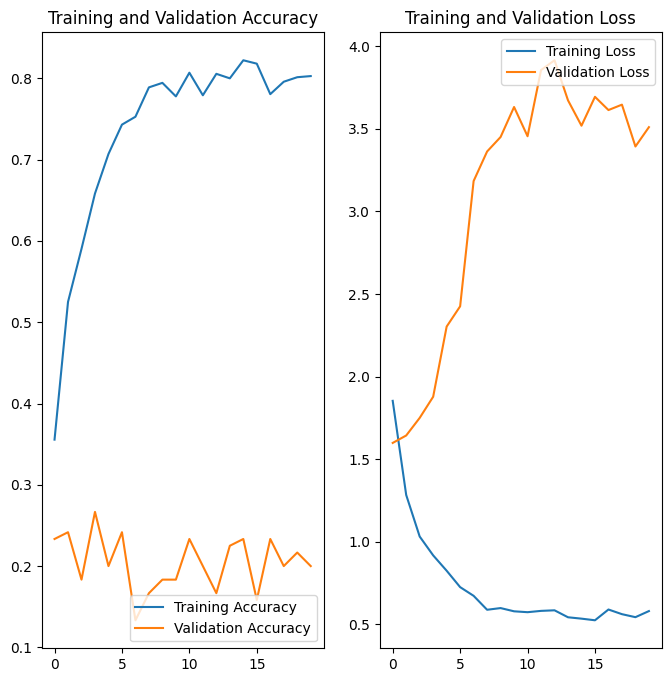

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Creating the second model for a better performance
## model 2

In [23]:
new_batch_size = 30
train_generator = generator(train_path, train_doc, new_batch_size)
val_generator = generator(val_path, val_doc, new_batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 13, 80, 80, 32)    2624      
                                                                 
 activation (Activation)     (None, 13, 80, 80, 32)    0         
                                                                 
 batch_normalization (Batch  (None, 13, 80, 80, 32)    128       
 Normalization)                                                  
                                                                 
 max_pooling3d (MaxPooling3  (None, 6, 40, 40, 32)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 40, 40, 64)     16448     
                                                                 
 activation_1 (Activation)   (None, 6, 40, 40, 64)     0

In [24]:
num_epochs2=20
history2 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs2, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  gdrive/MyDrive/Colab Notebooks/Project_data/train ; batch size = 30
Epoch 1/20
12/12 [==============================] - ETA: 0s - loss: 0.6163 - categorical_accuracy: 0.7833Source path =  gdrive/MyDrive/Colab Notebooks/Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2023-10-2810_07_51.351354/model-00001-0.61634-0.78333-3.13867-0.20000.h5
12/12 [==============================] - 64s 5s/step - loss: 0.6163 - categorical_accuracy: 0.7833 - val_loss: 3.1387 - val_categorical_accuracy: 0.2000 - lr: 0.0100
Epoch 2/20
12/12 [==============================] - ETA: 0s - loss: 0.7320 - categorical_accuracy: 0.7500
Epoch 2: saving model to model_init_2023-10-2810_07_51.351354/model-00002-0.73196-0.75000-2.66125-0.30000.h5
12/12 [==============================] - 55s 5s/step - loss: 0.7320 - categorical_accuracy: 0.7500 - val_loss: 2.6612 - val_categorical_accuracy: 0.3000 - lr: 0.0100
Epoch 3/20
12/12 [==============================] - ETA: 0s - loss: 0.6301

## Lecture ref Model 3

In [20]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,18,84,84,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    if item < len(imgs):
                      image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                      if image.shape[1] == 160:
                          image = resize(image,(84,84)).astype(np.float32)
                      else:
                          image = resize(image,(84,84)).astype(np.float32)

                      batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                      batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                      batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,84,84,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    if item < len(imgs):
                      image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                      if image.shape[1] == 160:
                          # image = imresize(image[:,20:140,:],(84,84)).astype(np.float32)
                          image = resize(image,(84,84)).astype(np.float32)
                      else:
                          image = resize(image,(84,84)).astype(np.float32)

                      batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                      batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                      batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [21]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

model = Sequential()
model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,84,84,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

# model.add(Dropout(0.25))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

# model.add(Dropout(0.25))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [22]:
optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 84, 84, 64)    5248      
                                                                 
 batch_normalization (Batch  (None, 18, 84, 84, 64)    256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 18, 84, 84, 64)    0         
                                                                 
 max_pooling3d (MaxPooling3  (None, 9, 42, 84, 64)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 42, 84, 128)    221312    
                                                                 
 batch_normalization_1 (Bat  (None, 9, 42, 84, 128)   

In [23]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [24]:
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


In [25]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [26]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [27]:
history3 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  gdrive/MyDrive/Colab Notebooks/Project_data/train ; batch size = 16
Epoch 1/25
42/42 [==============================] - ETA: 0s - loss: 4.4107 - categorical_accuracy: 0.3409 Source path =  gdrive/MyDrive/Colab Notebooks/Project_data/val ; batch size = 16

Epoch 1: saving model to model_init_2023-10-2917_17_09.681714/model-00001-4.41069-0.34087-6.26626-0.24000.h5
42/42 [==============================] - 709s 17s/step - loss: 4.4107 - categorical_accuracy: 0.3409 - val_loss: 6.2663 - val_categorical_accuracy: 0.2400 - lr: 0.0100
Epoch 2/25
42/42 [==============================] - ETA: 0s - loss: 1.8851 - categorical_accuracy: 0.3967
Epoch 2: saving model to model_init_2023-10-2917_17_09.681714/model-00002-1.88515-0.39668-2.66274-0.31000.h5
42/42 [==============================] - 129s 3s/step - loss: 1.8851 - categorical_accuracy: 0.3967 - val_loss: 2.6627 - val_categorical_accuracy: 0.3100 - lr: 0.0100
Epoch 3/25
42/42 [==============================] - ETA: 0s - loss: 1.

In [29]:
print("Total Params:", model.count_params())

Total Params: 15021653


<Figure size 1000x1000 with 0 Axes>

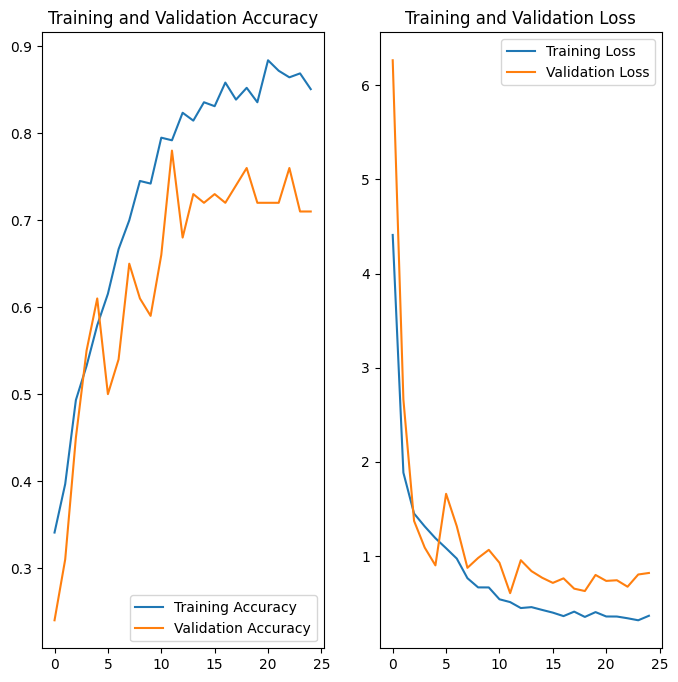

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))

acc = history3.history['categorical_accuracy']
val_acc = history3.history['val_categorical_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Creating the fourth model for a better performance
### Model 4
### using CNN +RNN

In [8]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,15,120,120,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    if item < len(imgs):
                      image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                      if image.shape[1] == 160:
                          image = image[:,20:140,:].astype(np.float32)
                      else:
                          image = resize(image,(120,120)).astype(np.float32)

                      batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                      batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                      batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    if item < len(imgs):
                      image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                      if image.shape[1] == 160:
                          image = image[:,20:140,:].astype(np.float32)
                      else:
                          image = resize(image,(120,120)).astype(np.float32)

                      batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                      batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                      batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = project_folder + '/' + 'train' #'Project_data\\train'
val_path = project_folder + '/' + 'val'  #'Project_data\\val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [28]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.vgg16 import VGG16

base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)
#x.add(Dropout(0.5))
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [11]:
optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 15, 64)            15009664  
 ributed)                                                        
                                                                 
 gru (GRU)                   (None, 15, 32)            9408      
                                                                 
 gru_1 (GRU)                 (None, 16)                2400      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 5)                 45        
                                                        

In [12]:
batch_size = 16

In [13]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [14]:
model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [16]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  gdrive/MyDrive/Colab Notebooks/Project_data/train ; batch size = 16
Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 1.6404 - categorical_accuracy: 0.2051  Source path =  gdrive/MyDrive/Colab Notebooks/Project_data/val ; batch size = 16

Epoch 1: saving model to model_init_conv_lstm_2023-10-2917_17_09.681714/model-00001-1.64038-0.20513-1.52383-0.27000.h5
42/42 [==============================] - 3124s 76s/step - loss: 1.6404 - categorical_accuracy: 0.2051 - val_loss: 1.5238 - val_categorical_accuracy: 0.2700 - lr: 0.0100
Epoch 2/20
42/42 [==============================] - ETA: 0s - loss: 1.5912 - categorical_accuracy: 0.2202
Epoch 2: saving model to model_init_conv_lstm_2023-10-2917_17_09.681714/model-00002-1.59122-0.22021-1.49676-0.37000.h5
42/42 [==============================] - 86s 2s/step - loss: 1.5912 - categorical_accuracy: 0.2202 - val_loss: 1.4968 - val_categorical_accuracy: 0.3700 - lr: 0.0100
Epoch 3/20
42/42 [==============================]

### Conclusion  categorical_accuracy: 0.7919  and  val_categorical_accuracy: 0.7600

## Creating the 5th model
### Model 5
### CNN + RNN

In [31]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,15,120,120,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    if item < len(imgs):
                      image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                      if image.shape[1] == 160:
                          image = image[:,20:140,:].astype(np.float32)
                      else:
                          image = resize(image,(120,120)).astype(np.float32)

                      batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                      batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                      batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    if item < len(imgs):
                      image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                      if image.shape[1] == 160:
                          image = image[:,20:140,:].astype(np.float32)
                      else:
                          image = resize(image,(120,120)).astype(np.float32)

                      batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                      batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                      batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [32]:
curr_dt_time = datetime.datetime.now()
train_path = project_folder + '/' + 'train' #'Project_data\\train'
val_path = project_folder + '/' + 'val'  #'Project_data\\val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


In [33]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.vgg16 import VGG16

base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)
#x.add(Dropout(0.5))
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [34]:
optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDi  (None, 15, 64)            15009664  
 stributed)                                                      
                                                                 
 gru_4 (GRU)                 (None, 15, 32)            9408      
                                                                 
 gru_5 (GRU)                 (None, 16)                2400      
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 8)                 136       
                                                                 
 dense_10 (Dense)            (None, 5)                 45        
                                                      

In [35]:
batch_size = 25

In [36]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [37]:
model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [38]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history5 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  gdrive/MyDrive/Colab Notebooks/Project_data/train ; batch size = 25
Epoch 1/50
27/27 [==============================] - ETA: 0s - loss: 1.6497 - categorical_accuracy: 0.2262Source path =  gdrive/MyDrive/Colab Notebooks/Project_data/val ; batch size = 25

Epoch 1: saving model to model_init_conv_lstm_2023-10-2919_45_11.004835/model-00001-1.64973-0.22624-1.58789-0.23000.h5
27/27 [==============================] - 109s 3s/step - loss: 1.6497 - categorical_accuracy: 0.2262 - val_loss: 1.5879 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/50
27/27 [==============================] - ETA: 0s - loss: 1.6150 - categorical_accuracy: 0.2655
Epoch 2: saving model to model_init_conv_lstm_2023-10-2919_45_11.004835/model-00002-1.61504-0.26546-1.58708-0.31000.h5
27/27 [==============================] - 94s 4s/step - loss: 1.6150 - categorical_accuracy: 0.2655 - val_loss: 1.5871 - val_categorical_accuracy: 0.3100 - lr: 0.0100
Epoch 3/50
27/27 [==============================] - E

## Creating the 6th model
### Model 6

In [8]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,15,120,120,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    if item < len(imgs):
                      image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                      if image.shape[1] == 160:
                          image = image[:,20:140,:].astype(np.float32)
                      else:
                          image = resize(image,(120,120)).astype(np.float32)

                      batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                      batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                      batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    if item < len(imgs):
                      image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                      if image.shape[1] == 160:
                          image = image[:,20:140,:].astype(np.float32)
                      else:
                          image = resize(image,(120,120)).astype(np.float32)

                      batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                      batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                      batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = project_folder + '/' + 'train' #'Project_data\\train'
val_path = project_folder + '/' + 'val'  #'Project_data\\val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


In [10]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.vgg16 import VGG16

base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)
#x.add(Dropout(0.5))
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

58889256/58889256 [==============================] - 0s 0us/step


In [11]:
optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 15, 64)            15009664  
 ributed)                                                        
                                                                 
 gru (GRU)                   (None, 15, 32)            9408      
                                                                 
 gru_1 (GRU)                 (None, 16)                2400      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 5)                 45        
                                                        

In [12]:
batch_size = 20

In [13]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [14]:
model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history6 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  gdrive/MyDrive/Colab Notebooks/Project_data/train ; batch size = 20
Epoch 1/50
34/34 [==============================] - ETA: 0s - loss: 1.6412 - categorical_accuracy: 0.2353  Source path =  gdrive/MyDrive/Colab Notebooks/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_conv_lstm_2023-10-3004_13_37.027696/model-00001-1.64124-0.23529-1.56414-0.34000.h5
34/34 [==============================] - 4304s 130s/step - loss: 1.6412 - categorical_accuracy: 0.2353 - val_loss: 1.5641 - val_categorical_accuracy: 0.3400 - lr: 0.0100
Epoch 2/50
34/34 [==============================] - ETA: 0s - loss: 1.5625 - categorical_accuracy: 0.2549
Epoch 2: saving model to model_init_conv_lstm_2023-10-3004_13_37.027696/model-00002-1.56246-0.25490-1.52563-0.35000.h5
34/34 [==============================] - 84s 3s/step - loss: 1.5625 - categorical_accuracy: 0.2549 - val_loss: 1.5256 - val_categorical_accuracy: 0.3500 - lr: 0.0100
Epoch 3/50
34/34 [==============================

## The final output or the performance we discuss 
### Conclusion categorical_accuracy: 0.9216 and val_categorical_accuracy: 0.7800